In [1]:
import gc
import os
import glob
import zipfile
import warnings
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import cv2
import PIL
from PIL import ImageOps, ImageFilter, ImageDraw

In [2]:
DATA_PATH = './data/splitlabel/'
IMAGE_PATH = './data/467case_cut-20190916T015832Z-001/'
os.listdir(DATA_PATH)

['문-격자무늬 창.xlsx',
 '위치-집-아래.xlsx',
 '위치-집-정중앙.xlsx',
 '지면선-벽 밑면 있지만 지면 없음.xlsx',
 '지붕-그물무늬 음영.xlsx',
 '창문-격자무늬.xlsx',
 '창문-많다.xlsx',
 '창문-창문을 가린 커튼.xlsx']

In [3]:
house = ['문-격자무늬 창',
 '위치-집-아래',
 '위치-집-정중앙',
 '지면선-벽 밑면 있지만 지면 없음',
 '지붕-그물무늬 음영',
 '창문-격자무늬',
 '창문-많다',
 '창문-창문을 가린 커튼']

In [4]:
TRAIN_CROP_PATH = './train_crop'
TRAIN_IMG_PATH = os.path.join(IMAGE_PATH,'house')


df = []
for excel_name in house:
    df.append(pd.read_excel(os.path.join(DATA_PATH, excel_name + '.xlsx')))
    df[house.index(excel_name)] = df[house.index(excel_name)].drop('Unnamed: 0', axis=1)
    df[house.index(excel_name)]['data'] = df[house.index(excel_name)].data.apply(lambda x: f'{x:0>4}')
    

In [5]:
for i in range(len(house)):
    print(df[i].head(5))

         data  문-격자무늬 창
0  0001_H.jpg         1
1  0002_H.jpg         0
2  0004_H.jpg         0
3  0005_H.jpg         0
4  0006_H.jpg         0
         data  위치-집-아래
0  0001_H.jpg        0
1  0002_H.jpg        0
2  0004_H.jpg        0
3  0005_H.jpg        0
4  0006_H.jpg        0
         data  위치-집-정중앙
0  0001_H.jpg         1
1  0002_H.jpg         0
2  0004_H.jpg         0
3  0005_H.jpg         0
4  0006_H.jpg         0
         data  지면선-벽 밑면 있지만 지면 없음
0  0001_H.jpg                   0
1  0002_H.jpg                   0
2  0004_H.jpg                   0
3  0005_H.jpg                   0
4  0006_H.jpg                   1
         data  지붕-그물무늬 음영
0  0001_H.jpg           0
1  0002_H.jpg           0
2  0004_H.jpg           0
3  0005_H.jpg           0
4  0006_H.jpg           0
         data  창문-격자무늬
0  0001_H.jpg        0
1  0002_H.jpg        0
2  0004_H.jpg        0
3  0005_H.jpg        1
4  0006_H.jpg        1
         data  창문-많다
0  0001_H.jpg      0
1  0002_H.jpg      0
2  0004_H.jpg

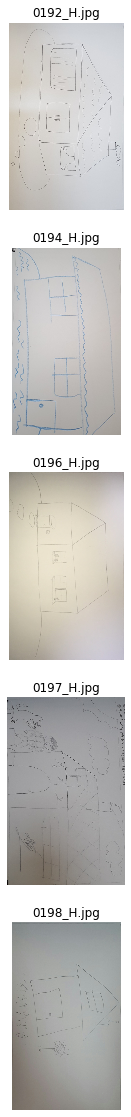

In [6]:
tmp_imgs = df[0]['data'][100:105]
plt.figure(figsize=(12,20))

for num, f_name in enumerate(tmp_imgs):
    img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, f_name))
    plt.subplot(5, 2, 2*num + 1)
    plt.title(f_name)
    plt.imshow(img)
    plt.axis('off')

In [7]:
from sklearn.model_selection import train_test_split

df[0][house[0]] = df[0][house[0]].astype('str')

df[0] = df[0][['data', house[0]]]


its = np.arange(df[0].shape[0])
train_idx, val_idx = train_test_split(its, train_size = 0.8, random_state=42)

X_train = df[0].iloc[train_idx, :]
X_val = df[0].iloc[val_idx, :]

print(X_train.shape)
print(X_val.shape)
print(df[0].shape)

(238, 2)
(60, 2)
(298, 2)


In [8]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [9]:
img_size = (224, 224)
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
nb_test_samples = len(df[0])
epochs = 20
batch_size = 32

# Define Generator config
train_datagen = ImageDataGenerator(
    horizontal_flip = True, 
    vertical_flip = False,
    preprocessing_function=preprocess_input
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Make Generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train, 
    directory=TRAIN_IMG_PATH,
    x_col = 'data',
    y_col = house[0],
    target_size = img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    seed=42
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=X_val, 
    directory=TRAIN_IMG_PATH,
    x_col='data',
    y_col=house[0],
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

C:\ProgramData\Anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="data". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 237 validated image filenames belonging to 2 classes.
Found 60 validated image filenames belonging to 2 classes.


In [10]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, GlobalAveragePooling2D

In [13]:
mobileNetModel = MobileNet(weights='imagenet', include_top=False)

model = Sequential()
model.add(mobileNetModel)
model.add(GlobalAveragePooling2D())
model.add(Dense(2, activation='softmax',kernel_initializer='he_normal'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, None, None, 1024)  3228864   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 3,230,914
Trainable params: 3,209,026
Non-trainable params: 21,888
_________________________________________________________________


In [14]:
from sklearn.metrics import f1_score

def micro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [19]:
def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0:
        return (num_samples // batch_size) + 1
    else : 
        return num_samples // batch_size

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

filepath = "my_mobile_model_{val_acc:.2f}_{val_loss:.4f}.h5"

ckpt = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=1, mode='auto')

callbackList = [ckpt]

history = model.fit_generator(
    train_generator,
    steps_per_epoch = get_steps(nb_train_samples, batch_size),
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = get_steps(nb_validation_samples, batch_size),
    callbacks = callbackList
)
gc.collect()

Epoch 1/20
7/8 [=========================>....] - ETA: 2:02 - loss: 1.2833 - acc: 0.218 - ETA: 1:05 - loss: 0.9941 - acc: 0.333 - ETA: 57s - loss: 0.8062 - acc: 0.532 - ETA: 46s - loss: 0.6875 - acc: 0.62 - ETA: 35s - loss: 0.5668 - acc: 0.70 - ETA: 23s - loss: 0.5783 - acc: 0.73 - ETA: 11s - loss: 0.4976 - acc: 0.7805
Epoch 00001: val_acc improved from -inf to 0.98333, saving model to my_mobile_model_0.98_0.1496.h5
8/8 [==============================] - 100s 12s/step - loss: 0.4339 - acc: 0.8101 - val_loss: 0.1496 - val_acc: 0.9833
Epoch 2/20
7/8 [=========================>....] - ETA: 1:21 - loss: 0.0052 - acc: 1.000 - ETA: 1:10 - loss: 0.2547 - acc: 0.968 - ETA: 58s - loss: 0.1744 - acc: 0.979 - ETA: 47s - loss: 0.1730 - acc: 0.96 - ETA: 35s - loss: 0.1502 - acc: 0.96 - ETA: 23s - loss: 0.1320 - acc: 0.96 - ETA: 11s - loss: 0.1185 - acc: 0.9688
Epoch 00002: val_acc did not improve from 0.98333
8/8 [==============================] - 89s 11s/step - loss: 0.1057 - acc: 0.9705 - val_los

7/8 [=========================>....] - ETA: 1:25 - loss: 6.6826e-05 - acc: 1.000 - ETA: 1:12 - loss: 0.0340 - acc: 0.9844    - ETA: 1:00 - loss: 0.0227 - acc: 0.989 - ETA: 40s - loss: 0.0171 - acc: 0.990 - ETA: 31s - loss: 0.0138 - acc: 0.99 - ETA: 21s - loss: 0.0116 - acc: 0.99 - ETA: 11s - loss: 0.0099 - acc: 0.9951
Epoch 00017: val_acc did not improve from 0.98333
8/8 [==============================] - 93s 12s/step - loss: 0.0089 - acc: 0.9958 - val_loss: 0.3767 - val_acc: 0.9833
Epoch 18/20
7/8 [=========================>....] - ETA: 1:25 - loss: 8.8083e-05 - acc: 1.000 - ETA: 1:12 - loss: 6.8490e-05 - acc: 1.000 - ETA: 1:00 - loss: 2.7414e-04 - acc: 1.000 - ETA: 40s - loss: 3.7227e-04 - acc: 1.000 - ETA: 32s - loss: 3.4493e-04 - acc: 1.00 - ETA: 21s - loss: 0.0017 - acc: 1.0000   - ETA: 10s - loss: 0.0134 - acc: 0.9951
Epoch 00018: val_acc did not improve from 0.98333
8/8 [==============================] - 91s 11s/step - loss: 0.0123 - acc: 0.9958 - val_loss: 0.3851 - val_acc: 0.9

2937

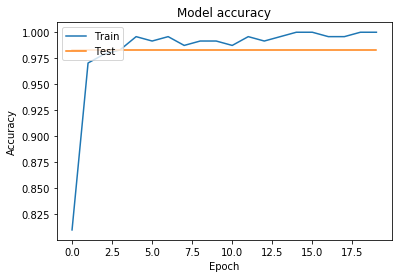

In [22]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

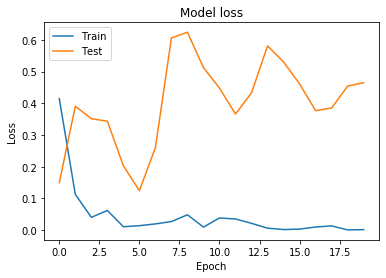

In [23]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [24]:
model_list = sorted([i for i in os.listdir() if "my_" in i])
model_list

['my_mobile_model_0.98_0.1496.h5']

In [25]:
model.load_weights(model_list[-1])

NameError: name 'test_generator' is not defined